In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt

%matplotlib notebook

In [2]:
# input
filepath_roadmap = '/media/ming/data/GeospatialData/ONrte/ONrte.shp'
filepath_gps = '/home/ming/Desktop/MapMatching/40.csv'

In [3]:
# load road map shapfile
gdf_roadmap = gpd.read_file(filepath_roadmap)
# load gps csv file
df = pd.read_csv(filepath_gps)
# convert to geo dataframe
gdf_point= gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.LONGITUDE, df.LATITUDE)
)

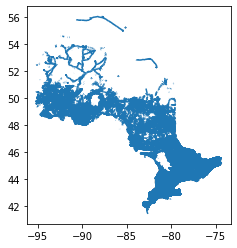

In [4]:
gdf_roadmap.plot()

In [5]:
# filter to a small area
lon_max, lon_min = df['LONGITUDE'].max() + 0.01, df['LONGITUDE'].min() - 0.01
lat_max, lat_min = df['LATITUDE'].max() + 0.01, df['LATITUDE'].min() - 0.01
rect_filter = shapely.geometry.box(lon_max, lat_max, lon_min, lat_min)
gdf_roadmap_filter = gdf_roadmap['geometry'].apply(rect_filter.intersects)

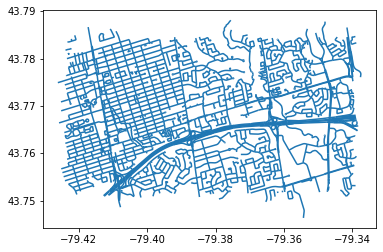

In [6]:
gdf_roadmap[gdf_roadmap_filter].plot()

In [7]:
# assign points to the nearest road
gdf_point['id_roadmap'] = gdf_point.geometry.apply(lambda x:
    gdf_roadmap[gdf_roadmap_filter].geometry.apply(x.distance).idxmin()
)

In [8]:
# visualization
import folium
import folium.plugins as plugins
import random


In [9]:
# map point to road segment
line_id_ls = gdf_point['id_roadmap'].unique()
r = lambda: random.randint(0,255)
line_id_dict = { _ : '#%02X%02X%02X' % (r(),r(),r()) for _ in line_id_ls}

In [10]:
MAP = folium.Map(location=[(lat_max + lat_min) / 2, (lon_max + lon_min) / 2], zoom_start=13)
# visualize
# line
for index in line_id_dict:
    line = gdf_roadmap.loc[index, 'geometry']
    locations = list(map(lambda x: [x[1], x[0]], line.coords[:]))
    folium.plugins.AntPath(locations,
                           color=line_id_dict[index],
                           delay=800
                           ).add_to(MAP)
# point
for index in gdf_point.index:
    point = [gdf_point.loc[index, 'LATITUDE'], gdf_point.loc[index, 'LONGITUDE']]
    line_id = gdf_point.loc[index, 'id_roadmap']
    folium.CircleMarker(point,
                        radius=6,
                  color=line_id_dict[line_id],
                        fill=True,
                        fill_color=line_id_dict[line_id]
                  ).add_to(MAP)
MAP

